In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc  # 计算roc和auc

# 设置sns样式
sns.set(style='white', context='notebook', palette='muted')

In [18]:
# 导入数据
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

""" 查看数据情况 """
# 分别查看实验数据集和预测数据集数据
print('实验数据大小:', train.shape)
print('预测数据大小:', test.shape, "\n")
# 分析：该数据集共1309条数据，其中实验数据891条，预测数据418条；实验数据比预测数据多了一列：即标签"result"

实验数据大小: (891, 12)
预测数据大小: (418, 11) 



In [19]:
# 记录数据异常值、缺失值情况，方便下一步进行数据预处理。将实验数据和预测数据合并
full = train.append(test, ignore_index=True)
print(full.info(), "\n")
# Age/Cabin/Embarked/Fare四项数据有缺失值，其中Cabin字段缺失近四分之三的数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None 



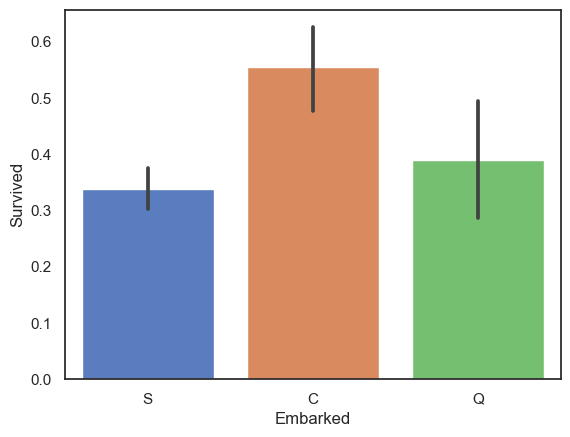

Embarked为"S"的乘客，其生存率为0.34
Embarked为"C"的乘客，其生存率为0.55
Embarked为"Q"的乘客，其生存率为0.39 



AttributeError: module 'seaborn' has no attribute 'factorplot'

In [20]:
""" 数据分析的过程：结合图表查看各个特征与标签间的关系 """
# Embarked与Survived：法国登船的乘客生存率较高
sns.barplot(data=train, x='Embarked', y='Survived')
plt.show()
# 计算不同类型embarked的乘客，其生存率为多少
print('Embarked为"S"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'S'].value_counts(normalize=True)[1])
print('Embarked为"C"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'C'].value_counts(normalize=True)[1])
print('Embarked为"Q"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'Q'].value_counts(normalize=True)[1], "\n")
# 法国登船乘客生存率较高原因可能与其头等舱乘客比例较高有关，因此继续查看不同登船地点乘客各舱位乘客数量情况
sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=3)
plt.show()
# 果然，法国登船的乘客其头等舱所占比例更高

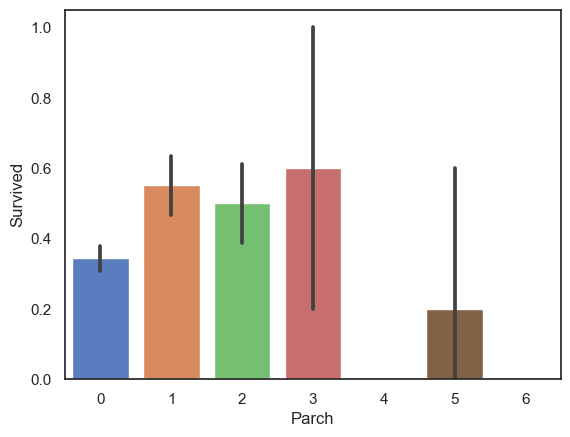

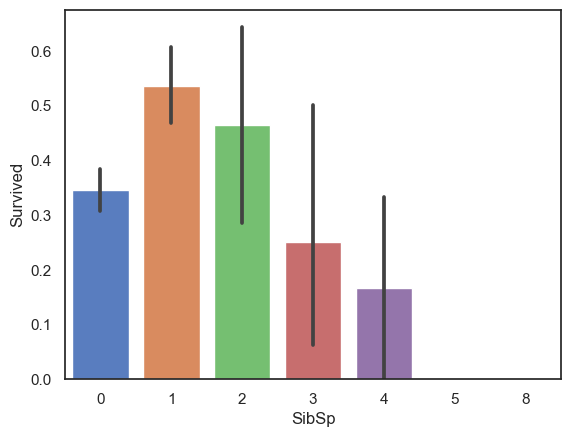

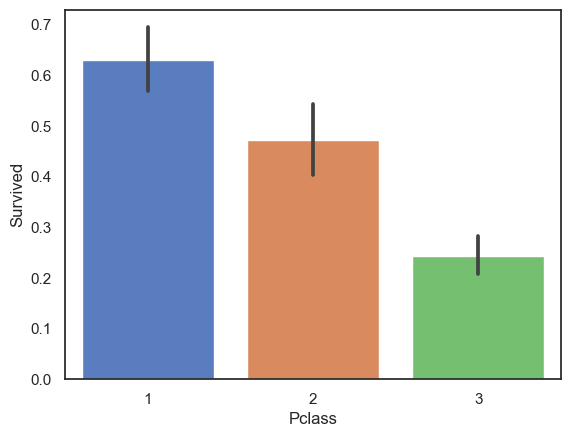

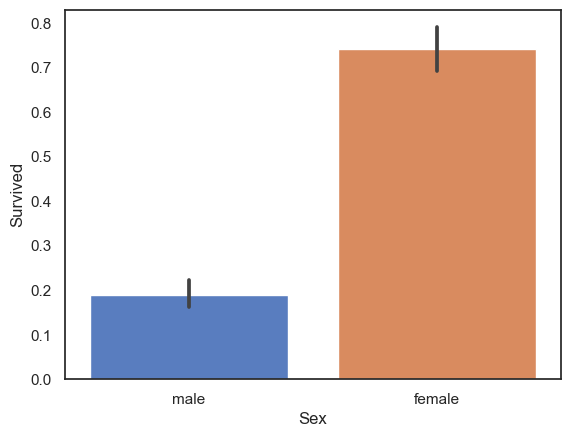

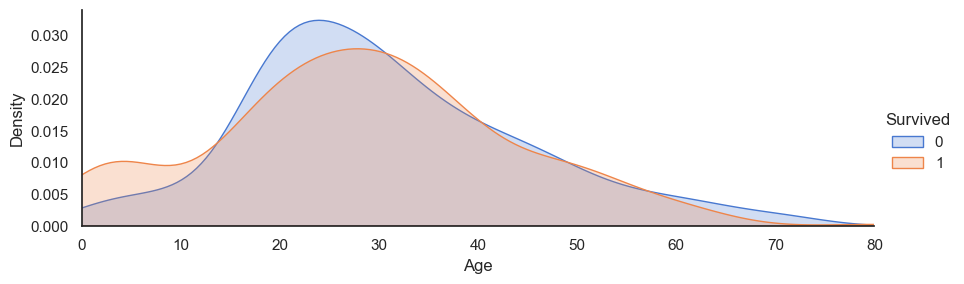

In [21]:
# Parch与Survived：当乘客同行的父母及子女数量适中时，生存率较高
sns.barplot(data=train, x='Parch', y='Survived')
plt.show()

# SibSp与Survived：当乘客同行的同辈数量适中时生存率较高
sns.barplot(data=train, x='SibSp', y='Survived')
plt.show()

# Pclass与Survived：乘客客舱等级越高，生存率越高
sns.barplot(data=train, x='Pclass', y='Survived')
plt.show()

# Sex与Survived：女性的生存率远高于男性
sns.barplot(data=train, x='Sex', y='Survived')
plt.show()

# Age与Survived：当乘客年龄段在0-10岁期间时生存率会较高
# 创建坐标轴
ageFacet = sns.FacetGrid(train, hue='Survived', aspect=3)
# 作图，选择图形类型
ageFacet.map(sns.kdeplot, 'Age', shade=True)
# 其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0, train['Age'].max()))
ageFacet.add_legend()
plt.show()

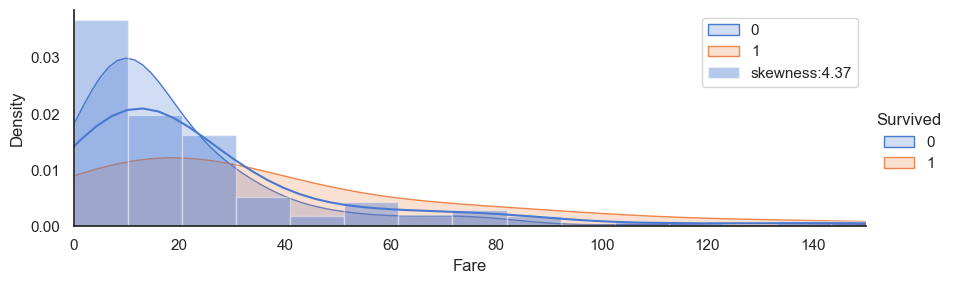

In [22]:
# Fare与Survived：当票价低于18左右时乘客生存率较低，票价越高生存率一般越高
# 创建坐标轴
ageFacet = sns.FacetGrid(train, hue='Survived', aspect=3)
ageFacet.map(sns.kdeplot, 'Fare', shade=True)
ageFacet.set(xlim=(0, 150))
ageFacet.add_legend()
# 查看fare分布
farePlot = sns.distplot(full['Fare'][full['Fare'].notnull()], label='skewness:%.2f' % (full['Fare'].skew()))
farePlot.legend(loc='best')
plt.show()
# fare的分布呈左偏的形态，其偏度skewness=4.37较大，说明数据偏移平均值较多，因此我们需要对数据进行对数化处理，防止数据权重分布不均匀。
# 对数化处理fare值
full['Fare'] = full['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
plt.show()

In [23]:
"""
数据预处理主要包括以下四个方面内容：
数据清洗（缺失值以及异常值的处理）
特征工程（基于对现有数据特征的理解构造的新特征，以挖掘数据的更多特点）
同组识别（找出具有明显同组效应且违背整体规律的数据，对其数据进行修正）
筛选子集（对数据进行降维，选择子集）
"""

"""
数据清洗
对数据的缺失值、异常值进行处理，便于对数据进一步分析。
本数据集有四个字段的数据存在缺失情况，即Cabin/Embarked/Fare/Age，未发现数据存在明显异常情况。
"""
# 对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
full['Cabin'] = full['Cabin'].fillna('U')
print(full['Cabin'].head(), "\n")
# 对Embarked缺失值进行处理，查看缺失值情况
print(full[full['Embarked'].isnull()], "\n")
# 查看Embarked数据分布情况，可知在英国南安普顿登船可能性最大，因此以此填充缺失值。
print(full['Embarked'].value_counts(), "\n")
full['Embarked'] = full['Embarked'].fillna('S')
# Fare缺失值填充。查看缺失数据情况，该乘客乘坐3等舱，登船港口为法国，舱位未知
print(full[full['Fare'].isnull()], "\n")
# 利用3等舱，登船港口为英国，舱位未知旅客的平均票价来填充缺失值。
full['Fare'] = full['Fare'].fillna(
    full[(full['Pclass'] == 3) & (full['Embarked'] == 'S') & (full['Cabin'] == 'U')]['Fare'].mean())

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object 

     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket      Fare Cabin Embarked  
61   female  38.0      0      0  113572  4.382027   B28      NaN  
829  female  62.0      0      0  113572  4.382027   B28      NaN   

S    914
C    270
Q    123
Name: Embarked, dtype: int64 

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: [] 



Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64 

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64 



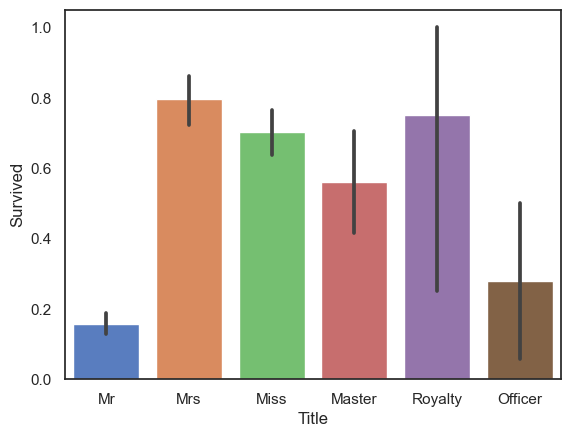

In [24]:
"""
特征工程
在理解原数据特征的基础上，特征工程通过对原有数据进行整合处理，得到新特征以反映数据更多信息。
"""
# Name中的头衔信息-Title。旅客姓名数据中包含头衔信息，不同头衔也可以反映旅客的身份，而不同身份的旅客其生存率有可能会出现较大差异。因此我们通过Name特征提取旅客头衔Title信息，并分析Title与Survived之间的关系。
# 构造新特征Title
full['Title'] = full['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
# 查看title数据分布
print(full['Title'].value_counts(), "\n")
# 将相近的Title信息整合在一起
TitleDict = {'Mr': 'Mr', 'Mlle': 'Miss', 'Miss': 'Miss', 'Master': 'Master', 'Jonkheer': 'Master', 'Mme': 'Mrs',
             'Ms': 'Mrs', 'Mrs': 'Mrs', 'Don': 'Royalty', 'Sir': 'Royalty', 'the Countess': 'Royalty',
             'Dona': 'Royalty', 'Lady': 'Royalty', 'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
             'Dr': 'Officer', 'Rev': 'Officer'}
full['Title'] = full['Title'].map(TitleDict)
print(full['Title'].value_counts(), "\n")
# 可视化分析Title与Survived之间关系
sns.barplot(data=full, x='Title', y='Survived')
plt.show()  # 头衔为'Mr'及'Officer'的乘客，生存率明显较低

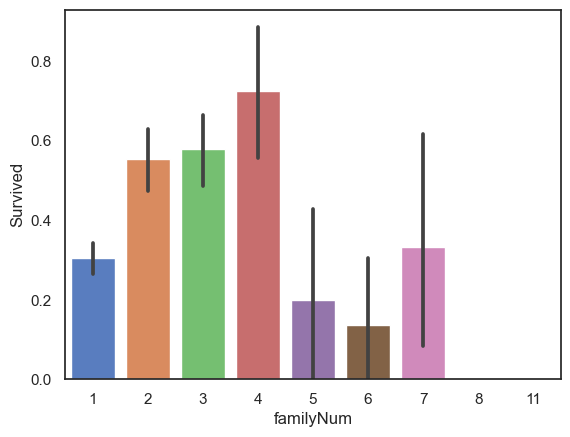

0    790
1    437
2     82
Name: familySize, dtype: int64 



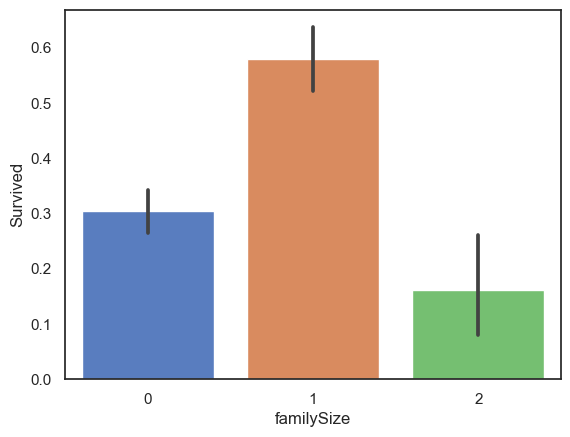

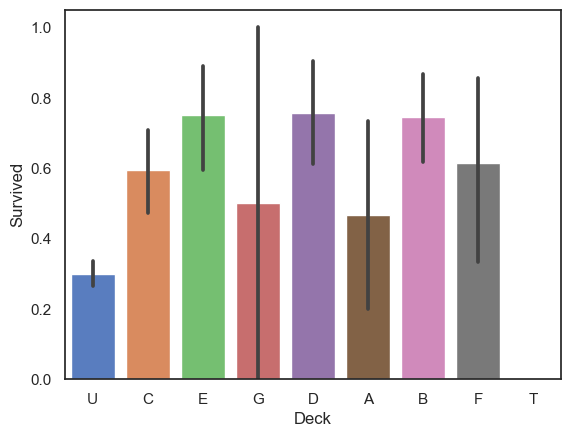

In [25]:
# FamilyNum及FamilySize信息.将Parch及SibSp字段整合得到一名乘客同行家庭成员总人数FamilyNum的字段，再根据家庭成员具体人数的多少得到家庭规模FamilySize这个新字段。
full['familyNum'] = full['Parch'] + full['SibSp'] + 1
# 查看familyNum与Survived
sns.barplot(data=full, x='familyNum', y='Survived')
plt.show() # 家庭成员人数在2-4人时，乘客的生存率较高，当没有家庭成员同行或家庭成员人数过多时生存率较低
# 我们按照家庭成员人数多少，将家庭规模分为“小、中、大”三类：
def familysize(familyNum):
    if familyNum == 1:
        return 0
    elif (familyNum >= 2) & (familyNum <= 4):
        return 1
    else:
        return 2


full['familySize'] = full['familyNum'].map(familysize)
print(full['familySize'].value_counts(), "\n")
# 查看familySize与Survived
sns.barplot(data=full, x='familySize', y='Survived')
plt.show()  # 当家庭规模适中时，乘客的生存率更高

# Cabin客舱类型信息-Deck。Cabin字段的首字母代表客舱的类型，也反映不同乘客群体的特点，可能也与乘客的生存率相关
# 提取Cabin字段首字母
full['Deck'] = full['Cabin'].map(lambda x: x[0])
# 查看不同Deck类型乘客的生存率
sns.barplot(data=full, x='Deck', y='Survived')
plt.show()  # 当乘客的客舱类型为C/B/D/E时，生存率较高；当客舱类型为U/T时，生存率较低。

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
Name: Ticket, dtype: int64 

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64 



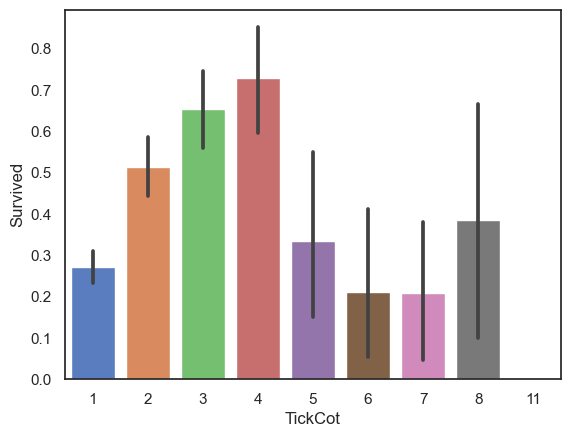

In [26]:
# 共票号乘客数量TickCot及TickGroup,同一票号的乘客数量可能不同，可能也与乘客生存率有关系。
# 提取各票号的乘客数量
TickCountDict = {}
TickCountDict = full['Ticket'].value_counts()
print(TickCountDict.head(), "\n")
# 将同票号乘客数量数据并入数据集中
full['TickCot'] = full['Ticket'].map(TickCountDict)
print(full['TickCot'].head(), "\n")
# 查看TickCot与Survived之间关系
sns.barplot(data=full, x='TickCot', y='Survived')
plt.show()  # 当TickCot大小适中时，乘客生存率较高。

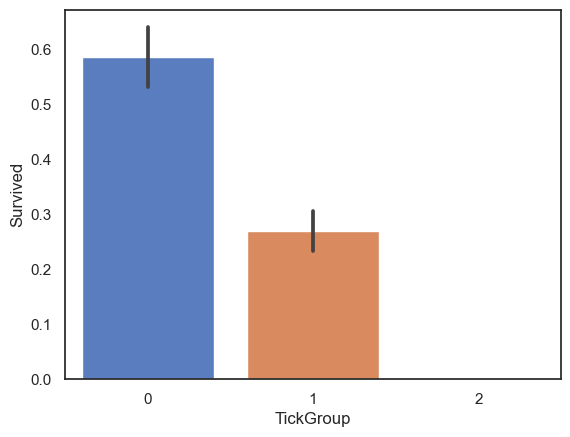

In [27]:
# 按照TickCot大小，将TickGroup分为三类。
def TickCountGroup(num):
    if (num >= 2) & (num <= 4):
        return 0
    elif (num == 1) | ((num >= 5) & (num <= 8)):
        return 1
    else:
        return 2


# 得到各位乘客TickGroup的类别
full['TickGroup'] = full['TickCot'].map(TickCountGroup)
# 查看TickGroup与Survived之间关系
sns.barplot(data=full, x='TickGroup', y='Survived')
plt.show()

In [28]:
# Age缺失值填充-构建随机森林模型预测缺失的数据
# 查看Age与Parch、Pclass、Sex、SibSp、Title、familyNum、familySize、Deck、TickCot、TickGroup等变量的相关系数大小，筛选出相关性较高的变量构建预测模型
# 查看缺失值情况
print(full[full['Age'].isnull()].head(), "\n")
# 筛选数据集
AgePre = full[['Age', 'Parch', 'Pclass', 'SibSp', 'Title', 'familyNum', 'TickCot']]
# 进行one-hot编码
AgePre = pd.get_dummies(AgePre)
ParAge = pd.get_dummies(AgePre['Parch'], prefix='Parch')
SibAge = pd.get_dummies(AgePre['SibSp'], prefix='SibSp')
PclAge = pd.get_dummies(AgePre['Pclass'], prefix='Pclass')
# 查看变量间相关性
AgeCorrDf = pd.DataFrame()
AgeCorrDf = AgePre.corr()
print(AgeCorrDf['Age'].sort_values(), "\n")
# 拼接数据
AgePre = pd.concat([AgePre, ParAge, SibAge, PclAge], axis=1)
print(AgePre.head(), "\n")

    PassengerId  Survived  Pclass                           Name     Sex  Age  \
5             6       0.0       3               Moran, Mr. James    male  NaN   
17           18       1.0       2   Williams, Mr. Charles Eugene    male  NaN   
19           20       1.0       3        Masselmani, Mrs. Fatima  female  NaN   
26           27       0.0       3        Emir, Mr. Farred Chehab    male  NaN   
28           29       1.0       3  O'Dwyer, Miss. Ellen "Nellie"  female  NaN   

    SibSp  Parch  Ticket      Fare Cabin Embarked Title  familyNum  \
5       0      0  330877  2.135148     U        Q    Mr          1   
17      0      0  244373  2.564949     U        S    Mr          1   
19      0      0    2649  1.977547     U        C   Mrs          1   
26      0      0    2631  1.977547     U        C    Mr          1   
28      0      0  330959  2.064226     U        Q  Miss          1   

    familySize Deck  TickCot  TickGroup  
5            0    U        1          1  
17      

In [29]:
# 拆分数据并建立模型（利用随机森林构建模型）
# 拆分实验集和预测集
AgeKnown = AgePre[AgePre['Age'].notnull()]
AgeUnKnown = AgePre[AgePre['Age'].isnull()]
# 生成实验数据的特征和标签
AgeKnown_X = AgeKnown.drop(['Age'], axis=1)
AgeKnown_y = AgeKnown['Age']
# 生成预测数据的特征
AgeUnKnown_X = AgeUnKnown.drop(['Age'], axis=1)
# 利用随机森林构建模型
rfr = RandomForestRegressor(random_state=None, n_estimators=500, n_jobs=-1)
rfr.fit(AgeKnown_X, AgeKnown_y)
# 利用模型进行预测并填入原数据集中
# 模型得分
print(rfr.score(AgeKnown_X, AgeKnown_y), "\n")
# 预测年龄
AgeUnKnown_y = rfr.predict(AgeUnKnown_X)
# 填充预测数据
full.loc[full['Age'].isnull(), ['Age']] = AgeUnKnown_y
print(full.info(), "\n")  # 此时已无缺失值

0.5874937627418677 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  familyNum    1309 non-null   int64  
 14  familySize   1309 non-null   int64  
 15  Deck         1309 non-null   object 
 16  TickCot      1309 non-null   int64  
 17  TickGroup    1309 non-null   int64  
dtypes: float64(3), int64(8), ob

In [30]:
"""
同组识别
虽然通过分析数据已有特征与标签的关系可以构建有效的预测模型，但是部分具有明显共同特征的用户可能与整体模型逻辑并不一致。
如果将这部分具有同组效应的用户识别出来并对其数据加以修正，就可以有效提高模型的准确率。在Titancic案例中，我们主要探究相同姓氏的乘客是否存在明显的同组效应。
提取两部分数据，分别查看其“姓氏”是否存在同组效应（因为性别和年龄与乘客生存率关系最为密切，因此用这两个特征作为分类条件）：
1、12岁以上男性：找出男性中同姓氏均获救的部分；
2、女性以及年龄在12岁以下儿童：找出女性及儿童中同姓氏均遇难的部分。
"""
# 提取乘客的姓氏及相应的乘客数
full['Surname'] = full['Name'].map(lambda x: x.split(',')[0].strip())
SurNameDict = {}
SurNameDict = full['Surname'].value_counts()
full['SurnameNum'] = full['Surname'].map(SurNameDict)
# 将数据分为两组
MaleDf = full[(full['Sex'] == 'male') & (full['Age'] > 12) & (full['familyNum'] >= 2)]
FemChildDf = full[((full['Sex'] == 'female') | (full['Age'] <= 12)) & (full['familyNum'] >= 2)]
# 分析男性同组效应
MSurNamDf = MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
print(MSurNamDf.value_counts(), "\n")
# 大多数同姓氏的男性存在“同生共死”的特点，因此利用该同组效应，我们对生存率为1的姓氏里的男性数据进行修正，提升其预测为“可以幸存”的概率
# 获得生存率为1的姓氏
MSurNamDict = {}
MSurNamDict = MSurNamDf[MSurNamDf.values == 1].index
print(MSurNamDict, "\n")
# 分析女性及儿童同组效应
FCSurNamDf = FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
print(FCSurNamDf.value_counts(), "\n")
# 与男性组特征相似，女性及儿童也存在明显的“同生共死”的特点，因此利用同组效应，对生存率为0的姓氏里的女性及儿童数据进行修正，提升其预测为“并未幸存”的概率
# 获得生存率为0的姓氏
FCSurNamDict = {}
FCSurNamDict = FCSurNamDf[FCSurNamDf.values == 0].index
print(FCSurNamDict, "\n")
# 对数据集中这些姓氏的两组数据数据分别进行修正：
# 对数据集中这些姓氏的男性数据进行修正：1、性别改为女；2、年龄改为5。
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(MSurNamDict)) & (full['Sex'] == 'male'), 'Age'] = 5
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(MSurNamDict)) & (full['Sex'] == 'male'), 'Sex'] = 'female'
# 对数据集中这些姓氏的女性及儿童的数据进行修正：1、性别改为男；2、年龄改为60。
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(FCSurNamDict)) & (
        (full['Sex'] == 'female') | (full['Age'] <= 12)), 'Age'] = 60
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(FCSurNamDict)) & (
        (full['Sex'] == 'female') | (full['Age'] <= 12)), 'Sex'] = 'male'

0.0    89
1.0    19
0.5     3
Name: Survived, dtype: int64 

Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname') 

1.000000    115
0.000000     27
0.750000      2
0.333333      1
0.142857      1
Name: Survived, dtype: int64 

Index(['Ahlin', 'Arnold-Franchi', 'Barbara', 'Boulos', 'Bourke', 'Caram',
       'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Johnston', 'Jussila',
       'Lahtinen', 'Lefebre', 'Lobb', 'Palsson', 'Panula', 'Rice', 'Robins',
       'Rosblom', 'Sage', 'Skoog', 'Strom', 'Turpin', 'Van Impe',
       'Vander Planke', 'Zabour'],
      dtype='object', name='Surname') 



Pclass       -0.338481
TickGroup    -0.319278
Age          -0.059589
SibSp        -0.035322
familyNum     0.016639
TickCot       0.064962
Parch         0.081629
familySize    0.108631
Fare          0.331805
Survived      1.000000
Name: Survived, dtype: float64 



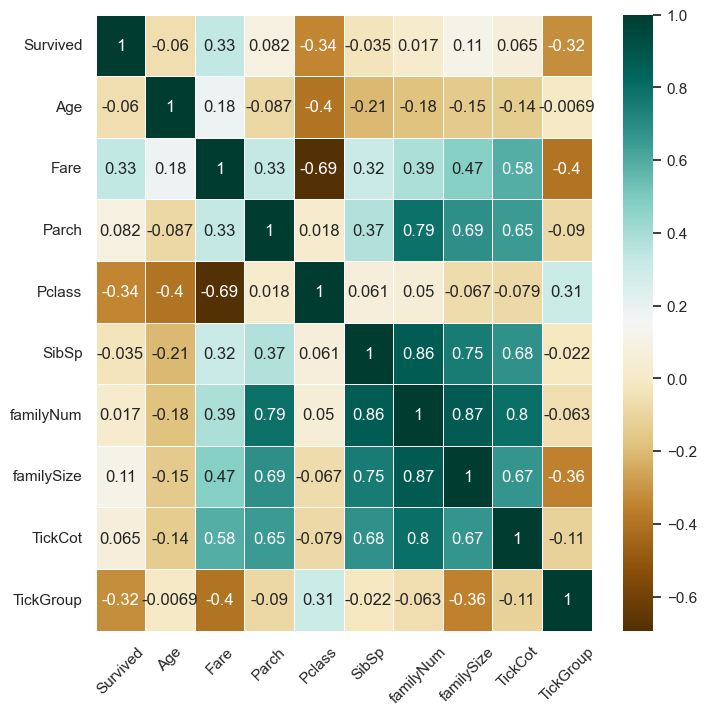

In [31]:
"""
筛选子集
在对数据进行分析处理的过程中，数据的维度更高了，为提升数据有效性需要对数据进行降维处理。
通过找出与乘客生存率“Survived”相关性更高的特征，剔除重复的且相关性较低的特征，从而实现数据降维。
"""
# 人工筛选
fullSel = full.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'Surname', 'SurnameNum'], axis=1)
# 查看各特征与标签的相关性
corrDf = pd.DataFrame()
corrDf = fullSel.corr()
print(corrDf['Survived'].sort_values(ascending=True), "\n")
# 通过绘制热力图，查看Survived与其他特征间相关性大小
plt.figure(figsize=(8, 8))
sns.heatmap(fullSel[['Survived', 'Age', 'Embarked', 'Fare', 'Parch', 'Pclass',
                     'Sex', 'SibSp', 'Title', 'familyNum', 'familySize', 'Deck',
                     'TickCot', 'TickGroup']].corr(), cmap='BrBG', annot=True, linewidths=.5)
plt.xticks(rotation=45)
plt.show()
# 先人工初步筛除与标签预测明显不相关或相关度很低的特征，再查看剩余特征与标签之间的相关性大小做进一步降维
fullSel = fullSel.drop(['familyNum', 'SibSp', 'TickCot', 'Parch'], axis=1)
# one-hot编码
fullSel = pd.get_dummies(fullSel)
PclassDf = pd.get_dummies(full['Pclass'], prefix='Pclass')
TickGroupDf = pd.get_dummies(full['TickGroup'], prefix='TickGroup')
familySizeDf = pd.get_dummies(full['familySize'], prefix='familySize')
fullSel = pd.concat([fullSel, PclassDf, TickGroupDf, familySizeDf], axis=1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

    cv_mean    cv_std            algorithm
0  0.763296  0.051620                  SVC
1  0.774482  0.056355      DecisionTreeCla
2  0.820474  0.048493      RandomForestCla
3  0.800262  0.042364        ExtraTreesCla
4  0.832809  0.037552  GradientBoostingCla
5  0.794657  0.038653                  KNN
6  0.830562  0.033666                   LR
7  0.823833  0.029460    LinearDiscrimiAna 



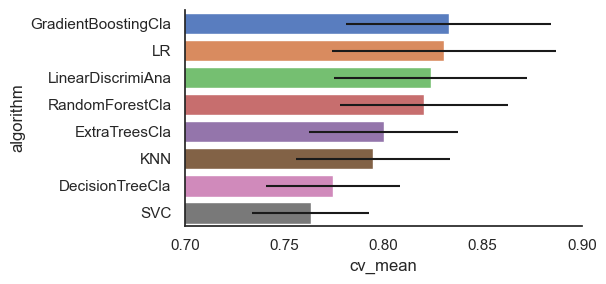

In [32]:
"""
构建模型
先比较了SCV/Decision Tree/Gradient Boosting/Neural network/KNN/Logistic Regression等多种机器学习算法的结果，
并对表现较好的Gradient Boosting及Logistic Regression做进一步的对比，最终选择Gradient Boosting对乘客生存率进行预测
"""
# 拆分实验数据与预测数据
experData = fullSel[fullSel['Survived'].notnull()]
preData = fullSel[fullSel['Survived'].isnull()]
experData_X = experData.drop('Survived', axis=1)
experData_y = experData['Survived']
preData_X = preData.drop('Survived', axis=1)
# 设置kfold，交叉采样法拆分数据集
kfold = StratifiedKFold(n_splits=10)

# 汇总不同模型算法
classifiers = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(),
               GradientBoostingClassifier(), KNeighborsClassifier(), LogisticRegression(), LinearDiscriminantAnalysis()]
# 比较各种算法结果，进一步选择模型
# 不同机器学习交叉验证结果汇总
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, experData_X, experData_y, scoring='accuracy', cv=kfold, n_jobs=-1))
# 求出模型得分的均值和标准差
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
# 汇总数据
cvResDf = pd.DataFrame({'cv_mean': cv_means, 'cv_std': cv_std,
                        'algorithm': ['SVC', 'DecisionTreeCla', 'RandomForestCla', 'ExtraTreesCla',
                                      'GradientBoostingCla', 'KNN', 'LR', 'LinearDiscrimiAna']})
print(cvResDf, "\n")
# 可视化查看不同算法的表现情况
cvResFacet = sns.FacetGrid(cvResDf.sort_values(by='cv_mean', ascending=False),
                           sharex=False, sharey=False, aspect=2)
cvResFacet.map(sns.barplot, 'cv_mean', 'algorithm', **{'xerr': cv_std}, palette='muted')
cvResFacet.set(xlim=(0.7, 0.9))
cvResFacet.add_legend()
plt.show()  # LR以及GradientBoostingCla模型在该问题中表现较好

In [33]:
"""
模型调优
综合以上模型表现，考虑选择GradientBoostingCla、LR两种模型进一步对比。
分别建立GradientBoostingClassifier以及LogisticRegression模型，并进行模型调优
"""
# GradientBoostingClassifier模型
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ["deviance"],
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100, 150],
                 'max_features': [0.3, 0.1]
                 }
modelgsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold,
                          scoring="accuracy", n_jobs=-1, verbose=1)
modelgsGBC.fit(experData_X, experData_y)
# LogisticRegression模型
modelLR = LogisticRegression()
LR_param_grid = {'C': [1, 2, 3], 'penalty': ['l1', 'l2']}
modelgsLR = GridSearchCV(modelLR, param_grid=LR_param_grid, cv=kfold,
                         scoring="accuracy", n_jobs=-1, verbose=1)
modelgsLR.fit(experData_X, experData_y)
# 查看模型准确度
# modelgsGBC模型
print('modelgsGBC模型得分为：%.3f' % modelgsGBC.best_score_, "\n")
# modelgsLR模型
print('modelgsLR模型得分为：%.3f' % modelgsLR.best_score_, "\n")
# GBC模型得分（即模型准确性）更高，继续比较其他指标的差异

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1

Fitting 10 folds for each of 6 candidates, totalling 60 fits
modelgsGBC模型得分为：0.841 

modelgsLR模型得分为：0.831 



/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/goodjob/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

<Figure size 640x480 with 0 Axes>

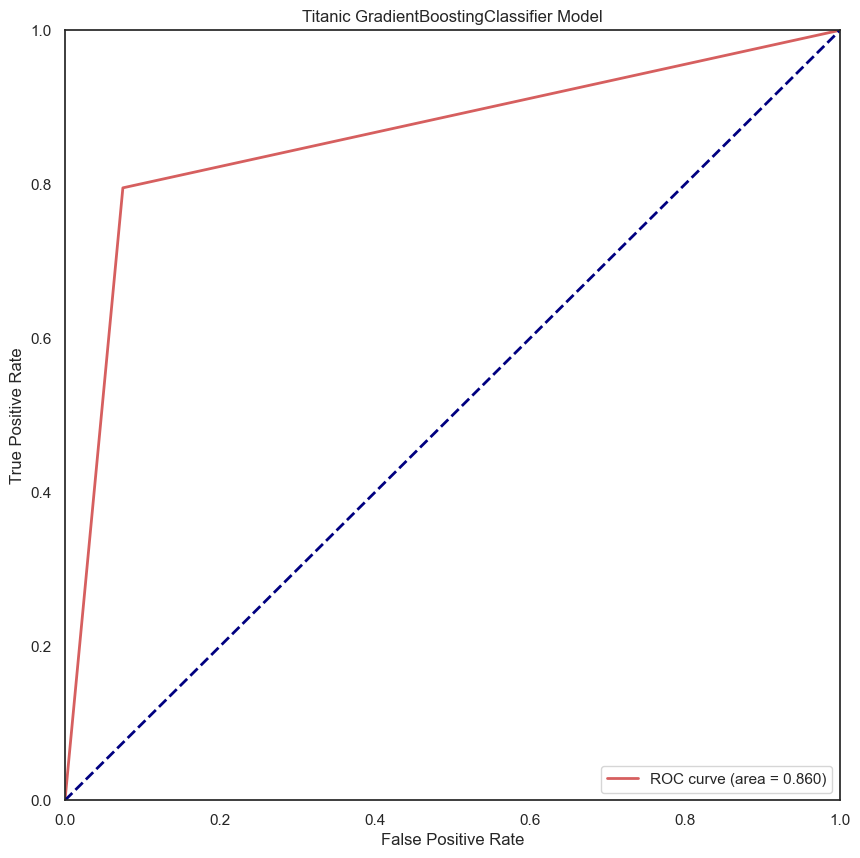

In [34]:
# 查看模型ROC曲线
# 求出测试数据模型的预测值
modelgsGBCtestpre_y = modelgsGBC.predict(experData_X).astype(int)
# 画图
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(experData_y, modelgsGBCtestpre_y)  # 计算真正率和假正率
roc_auc = auc(fpr, tpr)  # 计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic GradientBoostingClassifier Model')
plt.legend(loc="lower right")
plt.show()
# GradientBoostingClassifier和LogisticRegression模型ROC曲线均左上偏，AUC分别为0.824和0.810，即GradientBoostingClassifier模型效果较好

# 利用模型进行预测，并按规则导出预测结果
# TitanicGBSmodle
GBCpreData_y = modelgsGBC.predict(preData_X)
GBCpreData_y = GBCpreData_y.astype(int)
# 导出预测结果
GBCpreResultDf = pd.DataFrame()
GBCpreResultDf['PassengerId'] = full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived'] = GBCpreData_y
GBCpreResultDf
# 将预测结果导出为csv文件
GBCpreResultDf.to_csv('dataset/TitanicPredict.csv', index=False)